In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from time import time
from datetime import datetime
import numpy as np

import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

pd.options.display.max_columns = None

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Data Preparation

In [3]:
data = pd.read_csv('int20h-ds-test-dataset.csv', 
parse_dates=['event_created_date'],
)

In [4]:
event_frequencies = data.groupby(['userid', 'event_name']).size().unstack(fill_value=0)
event_frequencies.shape

(3540, 23)

In [5]:
event_frequencies.head(3)

event_name,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened
userid,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
000a59897372c5e3c147b15685fefc65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
001244c572f1a681553bc045a378cacf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [6]:
# Move target event columns to the beginning for convenience
target_name = 'Subscription Premium Cancel'
target_freq_col = event_frequencies.pop(target_name)
event_frequencies.insert(0, target_name, target_freq_col)
event_frequencies.head()

event_name,Subscription Premium Cancel,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Renew,Transaction Refund,Wallet Opened
userid,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
000a59897372c5e3c147b15685fefc65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
001244c572f1a681553bc045a378cacf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0032cb66b99f6baef57ec2aa04a9277f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
003f57fe2631ade57a86f6a2b96bb20c,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [7]:
event_frequencies.shape

(3540, 23)

In [8]:
event_frequencies['Subscription Premium Cancel'].value_counts()

0    3289
1     231
2      20
Name: Subscription Premium Cancel, dtype: int64

In [9]:
user_premium = event_frequencies[event_frequencies["Subscription Premium"] != 0]
user_premium.head()

event_name,Subscription Premium Cancel,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Renew,Transaction Refund,Wallet Opened
userid,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
00596aa4edee32815aaf4aad659c484e,0,0,0,0,0,2,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0
007b54670d72df309afd87befcbb63db,0,0,0,0,0,1,1,0,1,0,0,4,1,0,0,0,0,0,1,1,0,0,0
0136a8eeca5d16ac1a521dd0e27ecec0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,2,0,0
01529f53aaba5b512168d432d5650556,0,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [10]:
user_premium.shape

(711, 23)

In [11]:
user_premium_copy = user_premium.copy()
user_premium_copy["Simplified - Subscription Premium Cancel"] = user_premium["Subscription Premium Cancel"].apply(lambda x: int(bool(x)))

In [12]:
user_premium_copy.head()


event_name,Subscription Premium Cancel,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Renew,Transaction Refund,Wallet Opened,Simplified - Subscription Premium Cancel
userid,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
00596aa4edee32815aaf4aad659c484e,0,0,0,0,0,2,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0
007b54670d72df309afd87befcbb63db,0,0,0,0,0,1,1,0,1,0,0,4,1,0,0,0,0,0,1,1,0,0,0,0
0136a8eeca5d16ac1a521dd0e27ecec0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,2,0,0,0
01529f53aaba5b512168d432d5650556,0,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [13]:
user_premium_copy["Simplified - Subscription Premium Cancel"].unique()


array([0, 1], dtype=int64)

# Modeling

#### Train/test split

In [14]:

train, test = train_test_split(user_premium_copy, train_size=0.8, random_state=43)


In [24]:

y_train, y_test = train['Simplified - Subscription Premium Cancel'], test['Simplified - Subscription Premium Cancel']
x_train, x_test = train.drop(["Subscription Premium", 'Subscription Premium Cancel', 'Simplified - Subscription Premium Cancel'], axis=1), test.drop(["Subscription Premium", 'Subscription Premium Cancel', 'Simplified - Subscription Premium Cancel'], axis=1)

#### Modeling

In [25]:
models = [
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=5),
    LogisticRegression(solver='liblinear'),
    LogisticRegression(solver='saga'),
    RandomForestClassifier(),
    MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=1000)
]

results = dict()

for m in models:
    # education
    m.fit(x_train, y_train)

    # results
    results[type(m).__name__] = dict()
    results[type(m).__name__]["confusion matrix"] = confusion_matrix(y_test, m.predict(x_test))
    results[type(m).__name__]["accuracy score"] = accuracy_score(y_test, m.predict(x_test))
    results[type(m).__name__]["precision score"] = precision_score(y_test, m.predict(x_test))
    results[type(m).__name__]["recall score"] = recall_score(y_test, m.predict(x_test))
    results[type(m).__name__]["f1 score"] = f1_score(y_test, m.predict(x_test))
    
    print(f'model: {type(m).__name__}')
    print(f'confusion matrix: \n{results[type(m).__name__]["confusion matrix"]}')
    print(f"accuracy score:  {results[type(m).__name__]['accuracy score']}")


model: KNeighborsClassifier
confusion matrix: 
[[89 13]
 [12 29]]
accuracy score:  0.8251748251748252
model: KNeighborsClassifier
confusion matrix: 
[[88 14]
 [14 27]]
accuracy score:  0.8041958041958042
model: LogisticRegression
confusion matrix: 
[[94  8]
 [17 24]]
accuracy score:  0.8251748251748252
model: LogisticRegression
confusion matrix: 
[[93  9]
 [18 23]]
accuracy score:  0.8111888111888111


C:\Users\maks1\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


model: RandomForestClassifier
confusion matrix: 
[[93  9]
 [10 31]]
accuracy score:  0.8671328671328671
model: MLPClassifier
confusion matrix: 
[[89 13]
 [10 31]]
accuracy score:  0.8391608391608392


In [26]:
param_hyperopt = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}


In [27]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time()
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials)
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
        mod_name = "Gradient Boosting Decision Tree"
    else:
        boosting_type= 'dart'
        mod_name = "Multiple Additive Regression Trees"
    
    clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    clf_best.fit(X_train, y_train)
    
    # record results
    results[mod_name] = dict()
    results[mod_name]["confusion matrix"] = confusion_matrix(y_test, clf_best.predict(x_test))
    results[mod_name]["accuracy score"] = accuracy_score(y_test, clf_best.predict(x_test))

    results[mod_name]["precision score"] = precision_score(y_test, clf_best.predict(x_test))
    results[mod_name]["recall score"] = recall_score(y_test, clf_best.predict(x_test))
    results[mod_name]["f1 score"] = f1_score(y_test, clf_best.predict(x_test))  

    print("")
    print(f"##### Results {boosting_type}")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    
    print(f'confusion matrix: \n{results[mod_name]["confusion matrix"]}')
    print(f"accuracy score:  {results[mod_name]['accuracy score']}")
    
    print("Time elapsed: ", time() - start)
    print("Parameter combinations evaluated: ", num_eval)
  
    return trials

In [28]:
num_eval = 200

results_hyperopt = hyperopt(param_hyperopt, x_train, y_train, x_test, y_test, num_eval)

100%|██████████| 200/200 [00:37<00:00,  5.40trial/s, best loss: -0.8522123893805309]

##### Results dart
Score best parameters:  0.8522123893805309
Best parameters:  {'boosting_type': 1, 'colsample_by_tree': 0.9991941285675888, 'learning_rate': 0.10558927997681551, 'max_depth': 13.0, 'n_estimators': 21.0, 'num_leaves': 19.0, 'reg_lambda': 0.9289649765821599}
Test Score:  0.8251748251748252
confusion matrix: 
[[90 12]
 [13 28]]
accuracy score:  0.8251748251748252
Time elapsed:  37.10511755943298
Parameter combinations evaluated:  200


In [29]:
results_df = pd.DataFrame(results)
results_df.head()

,KNeighborsClassifier,LogisticRegression,RandomForestClassifier,MLPClassifier,Multiple Additive Regression Trees
confusion matrix,"[[88, 14], [14, 27]]","[[93, 9], [18, 23]]","[[93, 9], [10, 31]]","[[89, 13], [10, 31]]","[[90, 12], [13, 28]]"
accuracy score,0.804196,0.811189,0.867133,0.839161,0.825175
precision score,0.658537,0.71875,0.775,0.704545,0.7
recall score,0.658537,0.560976,0.756098,0.756098,0.682927
f1 score,0.658537,0.630137,0.765432,0.729412,0.691358


In [30]:
results_manual_df = results_df.drop(index="confusion matrix", axis=0)
results_manual_df.head()

,KNeighborsClassifier,LogisticRegression,RandomForestClassifier,MLPClassifier,Multiple Additive Regression Trees
accuracy score,0.804196,0.811189,0.867133,0.839161,0.825175
precision score,0.658537,0.71875,0.775,0.704545,0.7
recall score,0.658537,0.560976,0.756098,0.756098,0.682927
f1 score,0.658537,0.630137,0.765432,0.729412,0.691358


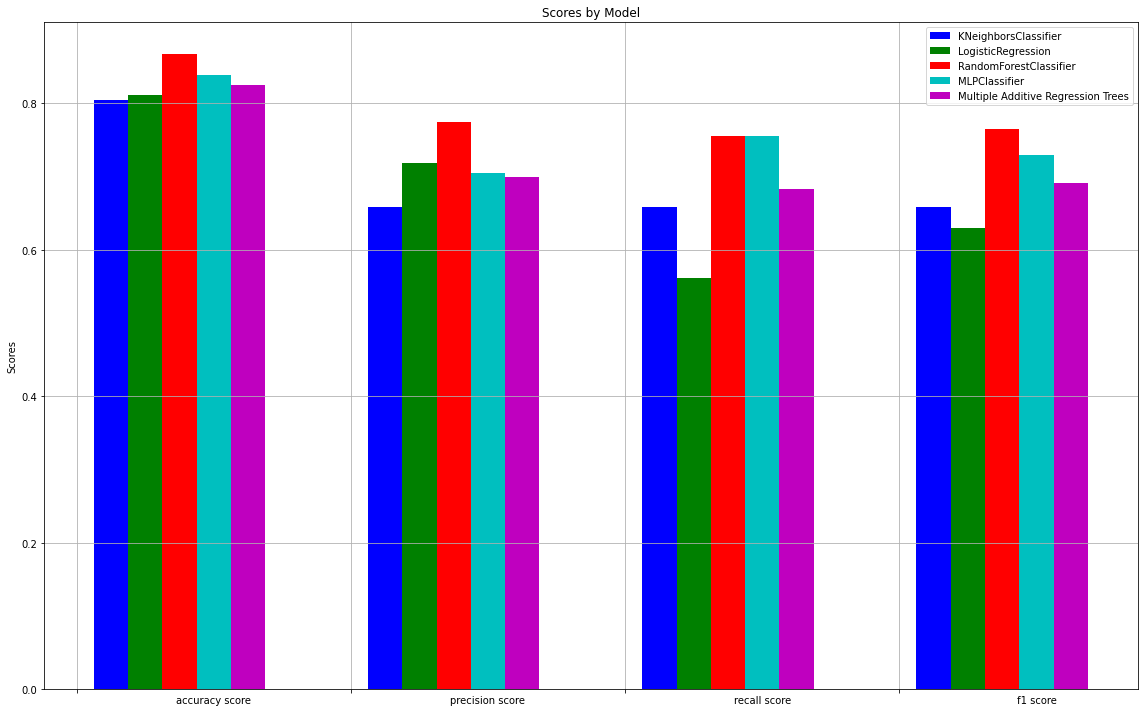

In [31]:
# data to plot
n_groups = len(results_manual_df.columns)

# create plot
fig, ax = plt.subplots(figsize=(16, 10))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8
bar_colors = ['b', 'g', 'r', 'c', 'm']
bar_labels = results_manual_df.columns[:]


# Setting the positions and width for the bars
pos = list(range(len(results_manual_df)))
num_col = len(results_manual_df.columns) - 1
width = 0.5 / num_col


for i, (colname, color, lbl) in enumerate(zip(results_manual_df.columns[:], bar_colors, bar_labels)):
    delta_p = 0.125 + width*i
    plt.bar([p + delta_p for p in pos], results_manual_df[colname], width, color=color, label=lbl)
    

ax.set_ylabel('Scores')
ax.set_title('Scores by Model')
ax.set_xticks(pos)

def update_ticks(x, pos):
    return results_manual_df.index[pos]

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(ticker.FuncFormatter(update_ticks))
ax.xaxis.set_minor_locator(ticker.FixedLocator([p+0.5 for p in pos]))
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
# plt.xlim(min(pos), max(pos)+1)
# plt.ylim([0, 10+max([max(results_manual_df[colname]) for colname in results_manual_df.columns[1:]])])
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




Summarising results based on received data from 5 models we can, for sure, state that the Random Forest Classifier model works better among them all. At the same time we can see that all those models show great and repetitive performance, but with some exceptions. K-Neighbors Classifier and Logistic Regression have lower performance compared with other models, they have pretty the same Accuracy and Precision, but they define Positive as Negative results more frequently and it significantly influences F1 score.

# Feature Importance

In [32]:
forest = models[4]

start_time = time()
importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.016 seconds


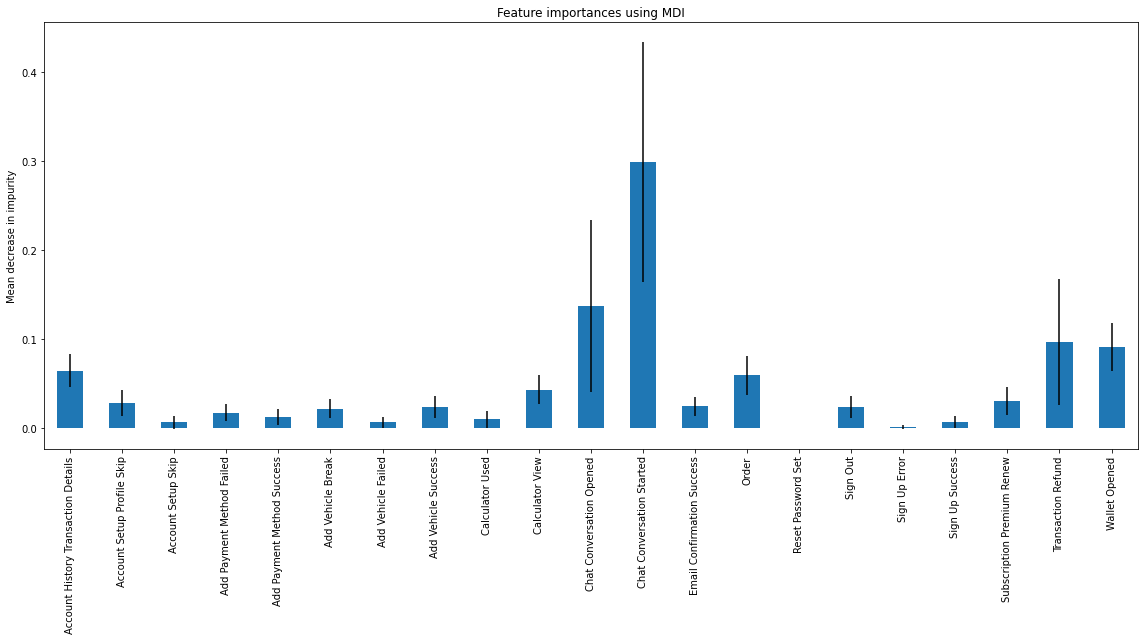

In [33]:
feature_names = [f"{i}" for i in x_test.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(16, 9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


We observe that Chat Conversation Opened and Chat Conversation Started features are found the most important. It's obviously right because user contacts the Support when something
is going wrong.

As result we can state that Chat Conversation Opened and Chat Conversation Started have the highest correlation with the account cancellation, at the oposite side there are Reset Password Set and Sign Up Error features which probably have the lowest correlation.